In [49]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=1000)

image_mean=np.mean(X_train,axis=0)

def feature_engineering(X):
    X=X.astype(float)
    X-=image_mean
    N=X.shape[0]
    X=X.reshape(N,-1)
    #bias trick
    X=np.concatenate((X,np.ones((N,1))),axis=1)
    
    return X
X_train=feature_engineering(X_train)
X_val=feature_engineering(X_val)
X_test=feature_engineering(X_test)
y_train=y_train.flatten()
y_val=y_val.flatten()
y_test=y_test.flatten()

In [51]:
def svm_loss_vectorized(X,y,W,reg):
    """
    X: shape (N,d)
    """
    N=X.shape[0]
    d,C=W.shape
    loss=0
    dW=np.zeros_like(W)
    
    Z=X.dot(W) #shape(N,C)
    id0=np.arange(N)
    
    margins=np.maximum(0,Z-(Z[id0,y]).reshape(N,1)+1) #shape of (N,C)
    margins[id0,y]=0
    loss=np.sum(margins)
    loss/=N
    loss+=0.5*reg*np.linalg.norm(W)**2
    
    F=(margins>0).astype(int) #shape of(N,C)
    F[id0,y]=np.sum(-F,axis=1)
    
    dW=X.T.dot(F)/N + reg*W
    return loss,dW

#mini_batch_gradien_descent
def multi_class_SVM(X,y,W_init,reg,lr=.1,batch_size=1000,epoches=50,print_every=10):
    N=X.shape[0]
    W=W_init
    loss_history=[]
    n_batches=int(np.ceil(X.shape[0]/float(batch_size)))
    for it in range(epoches):
        mix_idx=np.random.permutation(N)
        
        for ib in range(n_batches):
            ids=mix_idx[ib*batch_size:(ib+1)*batch_size]
            X_batch=X[ids]
            y_batch=y[ids]
            
            loss,dW=svm_loss_vectorized(X_batch,y_batch,W,reg)
            W-=lr*dW
            loss_history.append(loss)
            
        #if it%print_every==0:
            #print('epoch {}/{},'.format(it,epoches),'loss:',loss)
    
    return W,loss_history


IndentationError: expected an indented block (<ipython-input-51-7d53ae22cf9b>, line 46)

In [39]:
d,C=X_train.shape[1],10
W=.00001*np.random.rand(d,C)
reg=.1
W,loss_history=multi_class_SVM(X_train,y_train,W,reg=0.1,lr=1e-8,print_every=5)

epoch 0/50, loss: 6.591784801126247
epoch 5/50, loss: 5.585656384188264
epoch 10/50, loss: 5.081067487616426
epoch 15/50, loss: 4.900808801073525
epoch 20/50, loss: 4.670746770023425
epoch 25/50, loss: 4.973934094704613
epoch 30/50, loss: 4.808668275208203
epoch 35/50, loss: 4.984891502640611
epoch 40/50, loss: 4.587403184920028
epoch 45/50, loss: 4.654722226360427


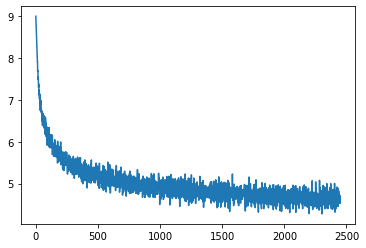

In [44]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_history)),loss_history)
plt.show()

In [52]:
d,C=X_train.shape[1],10
W=.00001*np.random.rand(d,C)
def predict(X,W):
    Z=X.dot(W) #shape of (N,C)
    return np.argmax(Z,axis=1)

def evaluate(X,y,W):
    y_pred=predict(X,W)
    acc=100*np.sum(np.equal(y_pred,y))/y.shape[0]
    return acc
acc=evaluate(X_test,y_test,W)


lrs=[1e-9,1e-8,1e-7,1e-6]
regs=[0.1,0.01,0.001,0.0001]
best_W=0
best_acc=0

for lr in lrs:
    for reg in regs:
        W,loss_history=multi_class_SVM(X_train,y_train,W,reg,lr,epoches=100,print_every=1e20)
        acc_val=evaluate(X_val,y_val,W)
        print('lr={}, reg={}, loss={},validation_accuracy={}'.format(lr,reg,loss_history[-1],acc_val))
        if acc_val>=best_acc:
            best_acc=acc_val
            best_W=W
            
    
        

epoch 0/100, loss: 8.570990041995097
lr=1e-09, reg=0.1, loss=5.173734487254067,validation_accuracy=32.8
epoch 0/100, loss: 5.021811203265277
lr=1e-09, reg=0.01, loss=4.845785875872983,validation_accuracy=33.8
epoch 0/100, loss: 4.690710020448899
lr=1e-09, reg=0.001, loss=4.598539589054559,validation_accuracy=34.0
epoch 0/100, loss: 4.61731001399914
lr=1e-09, reg=0.0001, loss=4.584293264230554,validation_accuracy=34.3
epoch 0/100, loss: 4.742598080805944
lr=1e-08, reg=0.1, loss=4.257817482430104,validation_accuracy=37.3
epoch 0/100, loss: 4.467084385534133
lr=1e-08, reg=0.01, loss=4.500568395496875,validation_accuracy=38.8
epoch 0/100, loss: 4.482235289903197
lr=1e-08, reg=0.001, loss=4.310664898960802,validation_accuracy=38.7
epoch 0/100, loss: 4.091968591799759
lr=1e-08, reg=0.0001, loss=4.32676418630189,validation_accuracy=38.7
epoch 0/100, loss: 4.259581913256798
lr=1e-07, reg=0.1, loss=3.9226694605868704,validation_accuracy=38.9
epoch 0/100, loss: 4.0607800098439455
lr=1e-07, reg=0

In [53]:
print(best_acc)

39.0
